In [1]:
import pandas as pd
import supporter
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import joblib
import random
import seaborn as sns

random.seed(7)

#Porcentaje de los datos de entrenamiento
train_size=0.8
#Porcentaje de los datos de Test
test_size=0.2

#Parrilla de hiper-parámetros para GridSearchCV
parameter_space = {
    'epochs': [10,20],
    'batch_size' : [10,100],
    '_filters': [16, 32],
    '_kernel_size': [1,2],
}

"""optimizer = ['SGD', 'Adam']
init_mode = ['glorot_uniform', 'normal', 'uniform']
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [50, 100, 500]
filters = [32, 64]
kernel_sizes = [2,4]"""

#Validación cruzada para series temporales
cv = TimeSeriesSplit(n_splits = 10)

In [2]:
def create_CNN_model(_optimizer='adam', _init_mode='uniform', _filters=64, _kernel_size=2):
    model = Sequential()
    model.add(Conv1D(filters=_filters, kernel_size=_kernel_size, kernel_initializer=_init_mode,
                     activation='relu', input_shape=(n_predictors, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, kernel_initializer=_init_mode, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=_optimizer, loss='mse')
    return model

#Encapsulamos el modelo keras para que sea compatatible con las funciones SkLearn
model_CNN = KerasRegressor(build_fn=create_CNN_model, verbose=0)

# 7 días sin información diaria

In [3]:
df_7d_no_info = pd.read_csv(r'./consumo_diario_03_7d_no_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [4]:
X_train_7d_no_info, X_test_7d_no_info, y_train_7d_no_info, y_test_7d_no_info = supporter.split_train_test_deep(df_7d_no_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_7d_no_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_CNN, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_7d_no_info, y_train_7d_no_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'CNN_7d_no_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_7d_no_info_RMSE, _7d_no_info_MAE, _7d_no_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                             X_train_7d_no_info,
                                                                                             y_train_7d_no_info,
                                                                                             cv,
                                                                                             '7 días sin información diaria')
joblib.dump(_7d_no_info_RMSE, 'CNN_7d_no_info_normalizado_RMSE_training.pkl')
joblib.dump(_7d_no_info_MAE, 'CNN_7d_no_info_normalizado_MAE_training.pkl')
joblib.dump(_7d_no_info_MAPE, 'CNN_7d_no_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('CNN_7d_no_info_normalizado_best_model.h5')

In [6]:
best_conf = joblib.load('CNN_7d_no_info_normalizado_best_conf.pkl')
best_conf

{'_filters': 16, '_kernel_size': 2, 'batch_size': 10, 'epochs': 20}

In [7]:
_7d_no_info_RMSE = joblib.load('CNN_7d_no_info_normalizado_RMSE_training.pkl')
_7d_no_info_MAE = joblib.load('CNN_7d_no_info_normalizado_MAE_training.pkl')
_7d_no_info_MAPE = joblib.load('CNN_7d_no_info_normalizado_MAPE_training.pkl')

In [8]:
predictor_7d_no_info = load_model('CNN_7d_no_info_normalizado_best_model.h5')

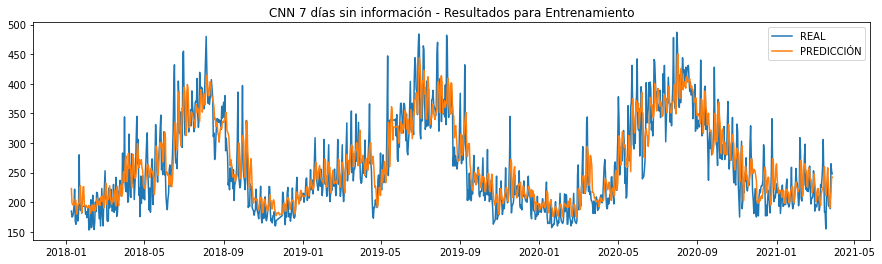

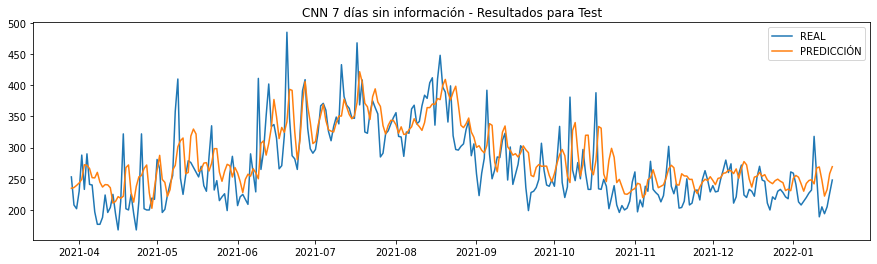

In [9]:
supporter.grafica_resultado(predictor_7d_no_info,"CNN 7 días sin información", df_7d_no_info,
                            train_size,test_size,show_scaled=False)

In [10]:
supporter.regression_results(y_test_7d_no_info, predictor_7d_no_info.predict(X_test_7d_no_info))

r2:  0.56
MAE:  0.09
MSE:  0.02
RMSE:  0.12
MAPE (%):  25.26


# 7 días con información diaria

In [11]:
df_7d_info = pd.read_csv(r'./consumo_diario_03_7d_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [12]:
X_train_7d_info, X_test_7d_info, y_train_7d_info, y_test_7d_info = supporter.split_train_test_deep(df_7d_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_7d_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_CNN, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_7d_info, y_train_7d_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'CNN_7d_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_7d_info_RMSE, _7d_info_MAE, _7d_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                         X_train_7d_info,
                                                                                         y_train_7d_info,
                                                                                         cv,
                                                                                         '7 días con información diaria')
joblib.dump(_7d_info_RMSE, 'CNN_7d_info_normalizado_RMSE_training.pkl')
joblib.dump(_7d_info_MAE, 'CNN_7d_info_normalizado_MAE_training.pkl')
joblib.dump(_7d_info_MAPE, 'CNN_7d_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('CNN_7d_info_normalizado_best_model.h5')

In [14]:
best_conf = joblib.load('CNN_7d_info_normalizado_best_conf.pkl')
best_conf

{'_filters': 32, '_kernel_size': 2, 'batch_size': 10, 'epochs': 20}

In [15]:
_7d_info_RMSE = joblib.load('CNN_7d_info_normalizado_RMSE_training.pkl')
_7d_info_MAE = joblib.load('CNN_7d_info_normalizado_MAE_training.pkl')
_7d_info_MAPE = joblib.load('CNN_7d_info_normalizado_MAPE_training.pkl')

In [16]:
predictor_7d_info = load_model('CNN_7d_info_normalizado_best_model.h5')

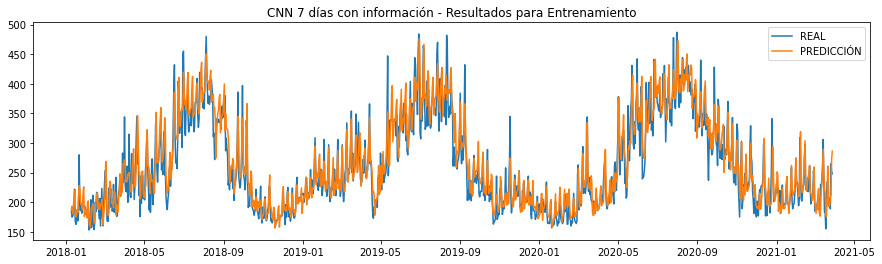

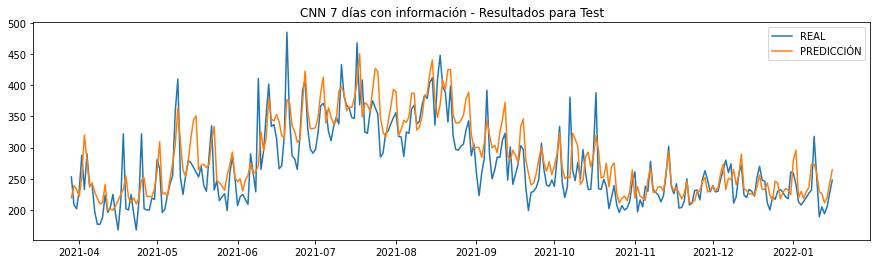

In [17]:
supporter.grafica_resultado(predictor_7d_info,"CNN 7 días con información", df_7d_info,
                            train_size,test_size,show_scaled=False)

In [18]:
supporter.regression_results(y_test_7d_info, predictor_7d_info.predict(X_test_7d_info))

r2:  0.7
MAE:  0.07
MSE:  0.01
RMSE:  0.1
MAPE (%):  21.15


# 14 días sin información diaria

In [19]:
df_14d_no_info = pd.read_csv(r'./consumo_diario_03_14d_no_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [20]:
X_train_14d_no_info, X_test_14d_no_info, y_train_14d_no_info, y_test_14d_no_info = supporter.split_train_test_deep(df_14d_no_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_14d_no_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_CNN, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_14d_no_info, y_train_14d_no_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'CNN_14d_no_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_14d_no_info_RMSE, _14d_no_info_MAE, _14d_no_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                                X_train_14d_no_info,
                                                                                                y_train_14d_no_info,
                                                                                                cv,
                                                                                            '14 días sin información diaria')
joblib.dump(_14d_no_info_RMSE, 'CNN_14d_no_info_normalizado_RMSE_training.pkl')
joblib.dump(_14d_no_info_MAE, 'CNN_14d_no_info_normalizado_MAE_training.pkl')
joblib.dump(_14d_no_info_MAPE, 'CNN_14d_no_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('CNN_14d_no_info_normalizado_best_model.h5')

In [22]:
best_conf = joblib.load('CNN_14d_no_info_normalizado_best_conf.pkl')
best_conf

{'_filters': 32, '_kernel_size': 1, 'batch_size': 10, 'epochs': 20}

In [23]:
_14d_no_info_RMSE = joblib.load('CNN_14d_no_info_normalizado_RMSE_training.pkl')
_14d_no_info_MAE = joblib.load('CNN_14d_no_info_normalizado_MAE_training.pkl')
_14d_no_info_MAPE = joblib.load('CNN_14d_no_info_normalizado_MAPE_training.pkl')

In [24]:
predictor_14d_no_info = load_model('CNN_14d_no_info_normalizado_best_model.h5')

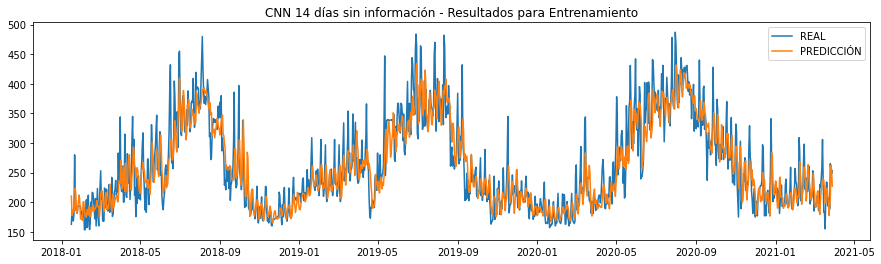

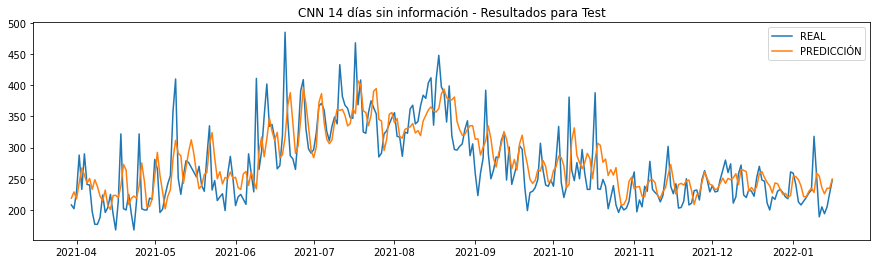

In [25]:
supporter.grafica_resultado(predictor_14d_no_info,"CNN 14 días sin información", df_14d_no_info,
                            train_size,test_size,show_scaled=False)

In [26]:
supporter.regression_results(y_test_14d_no_info, predictor_14d_no_info.predict(X_test_14d_no_info))

r2:  0.59
MAE:  0.09
MSE:  0.01
RMSE:  0.12
MAPE (%):  24.66


# 14 días con información diaria

In [27]:
df_14d_info = pd.read_csv(r'./consumo_diario_03_14d_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [28]:
X_train_14d_info, X_test_14d_info, y_train_14d_info, y_test_14d_info = supporter.split_train_test_deep(df_14d_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_14d_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_CNN, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_14d_info, y_train_14d_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'CNN_14d_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_14d_info_RMSE, _14d_info_MAE, _14d_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                       X_train_14d_info,
                                                                                       y_train_14d_info,
                                                                                       cv,
                                                                                       '14 días con información diaria')
joblib.dump(_14d_info_RMSE, 'CNN_14d_info_normalizado_RMSE_training.pkl')
joblib.dump(_14d_info_MAE, 'CNN_14d_info_normalizado_MAE_training.pkl')
joblib.dump(_14d_info_MAPE, 'CNN_14d_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('CNN_14d_info_normalizado_best_model.h5')

In [30]:
best_conf = joblib.load('CNN_14d_info_normalizado_best_conf.pkl')
best_conf

{'_filters': 32, '_kernel_size': 2, 'batch_size': 10, 'epochs': 20}

In [31]:
_14d_info_RMSE = joblib.load('CNN_14d_info_normalizado_RMSE_training.pkl')
_14d_info_MAE = joblib.load('CNN_14d_info_normalizado_MAE_training.pkl')
_14d_info_MAPE = joblib.load('CNN_14d_info_normalizado_MAPE_training.pkl')

In [32]:
predictor_14d_info = load_model('CNN_14d_info_normalizado_best_model.h5')

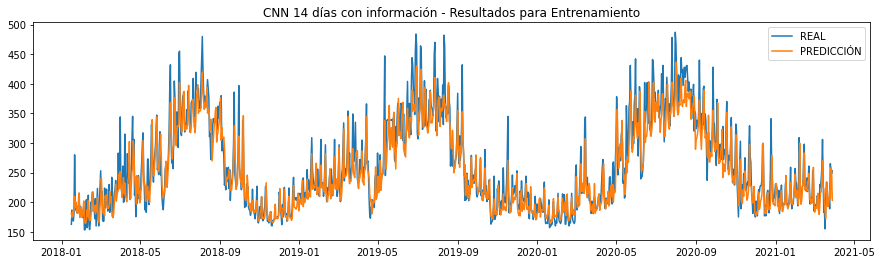

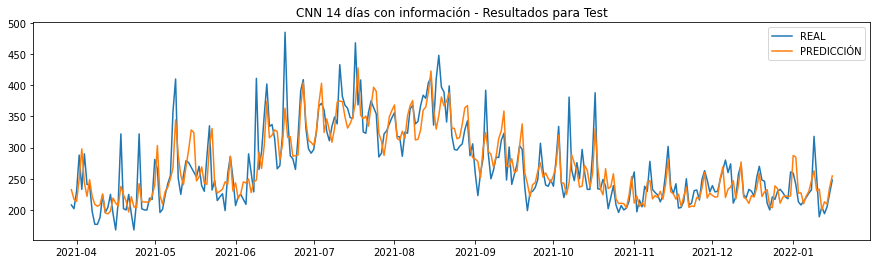

In [33]:
supporter.grafica_resultado(predictor_14d_info,"CNN 14 días con información", df_14d_info,
                            train_size,test_size,show_scaled=False)

In [34]:
supporter.regression_results(y_test_14d_info, predictor_14d_info.predict(X_test_14d_info))

r2:  0.71
MAE:  0.07
MSE:  0.01
RMSE:  0.1
MAPE (%):  20.6


# Juntamos todos los errores de entrenamiento

#### RMSE

In [35]:
errores_training_rmse = pd.concat([_7d_no_info_RMSE, _7d_info_RMSE, _14d_no_info_RMSE, _14d_info_RMSE], axis=1)
errores_training_rmse

,7 días sin información diaria,7 días con información diaria,14 días sin información diaria,14 días con información diaria
Pliegues,,,,
Pliegue 1,0.210227,0.154764,0.161202,0.155524
Pliegue 2,0.108797,0.168370,0.119356,0.101038
Pliegue 3,0.075692,0.081099,0.073622,0.105668
Pliegue 4,0.133315,0.109965,0.146337,0.110901
Pliegue 5,0.129326,0.122864,0.126399,0.105606
Pliegue 6,0.077755,0.072554,0.075989,0.061986
Pliegue 7,0.100636,0.072002,0.094896,0.076085
Pliegue 8,0.143050,0.103943,0.127609,0.124387
Pliegue 9,0.105377,0.094851,0.106808,0.078252


In [36]:
errores_training_rmse.to_csv("./CNN_rmse_training.csv")

[Text(0.5, 0, 'Dataset utilizado'), Text(0, 0.5, 'RMSE')]

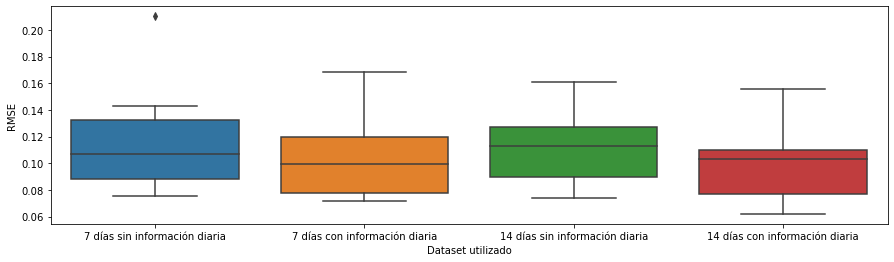

In [37]:
sns.boxplot(data=errores_training_rmse).set(xlabel='Dataset utilizado', ylabel='RMSE')

#### MAE

In [38]:
errores_training_mae = pd.concat([_7d_no_info_MAE, _7d_info_MAE, _14d_no_info_MAE, _14d_info_MAE], axis=1)
errores_training_mae

,7 días sin información diaria,7 días con información diaria,14 días sin información diaria,14 días con información diaria
Pliegues,,,,
Pliegue 1,0.153736,0.108393,0.106721,0.103179
Pliegue 2,0.067895,0.152520,0.065269,0.075930
Pliegue 3,0.045056,0.058507,0.042410,0.082912
Pliegue 4,0.077694,0.059617,0.086861,0.060431
Pliegue 5,0.066862,0.084200,0.073927,0.043627
Pliegue 6,0.048322,0.049068,0.045918,0.041512
Pliegue 7,0.051384,0.053075,0.058302,0.032707
Pliegue 8,0.080501,0.066110,0.069965,0.089856
Pliegue 9,0.062868,0.059043,0.063422,0.050306


In [39]:
errores_training_mae.to_csv("./CNN_mae_training.csv")

[Text(0.5, 0, 'Dataset utilizado'), Text(0, 0.5, 'MAE')]

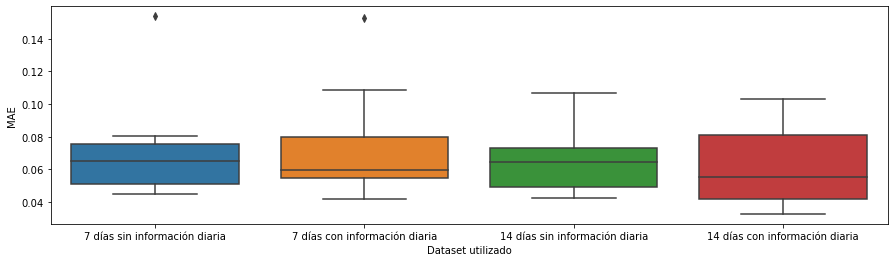

In [40]:
sns.boxplot(data=errores_training_mae).set(xlabel='Dataset utilizado', ylabel='MAE')

#### MAE

In [41]:
errores_training_mape = pd.concat([_7d_no_info_MAPE, _7d_info_MAPE, _14d_no_info_MAPE, _14d_info_MAPE], axis=1)
errores_training_mape

,7 días sin información diaria,7 días con información diaria,14 días sin información diaria,14 días con información diaria
Pliegues,,,,
Pliegue 1,35.390191,29.462897,30.020399,28.772567
Pliegue 2,56.698408,144.643784,55.016998,66.624511
Pliegue 3,30.404022,29.350395,27.909993,41.001746
Pliegue 4,33.147799,24.963642,31.323628,23.325313
Pliegue 5,25.024181,27.414430,26.463737,19.184174
Pliegue 6,83.684888,54.270201,80.628346,55.095825
Pliegue 7,46.083275,57.119778,56.573650,32.451771
Pliegue 8,18.287309,13.211018,16.305314,15.674924
Pliegue 9,31.162123,23.687575,31.431834,20.308960


In [42]:
errores_training_mape.to_csv("./CNN_mape_training.csv")

[Text(0.5, 0, 'Dataset utilizado'), Text(0, 0.5, 'MAPE')]

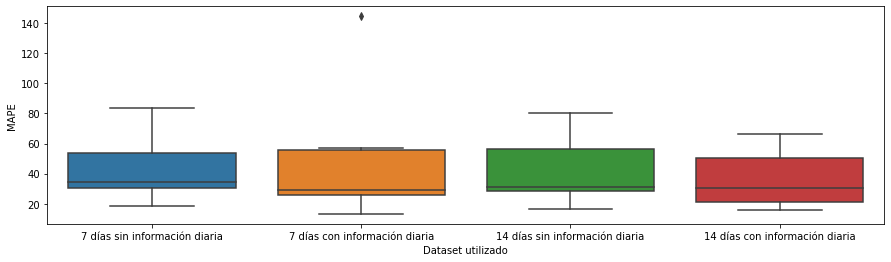

In [43]:
sns.boxplot(data=errores_training_mape).set(xlabel='Dataset utilizado', ylabel='MAPE')